# EVAC Examination

## Data Exploration

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math
from sklearn.metrics import r2_score


In [182]:
num_input_nodes = 8
num_hidden_nodes_1 = 16
num_hidden_nodes_2 = 16
num_output_nodes = 1

NUM_WEIGHTS = (num_input_nodes * num_hidden_nodes_1) + (num_hidden_nodes_1 * num_hidden_nodes_2) + (num_hidden_nodes_2 * num_output_nodes)
NUM_BIASES = num_hidden_nodes_1 + num_hidden_nodes_2 + num_output_nodes

IND_SIZE = NUM_WEIGHTS + NUM_BIASES

In [183]:
all_data = pd.read_csv('eScooterDemand.csv')
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


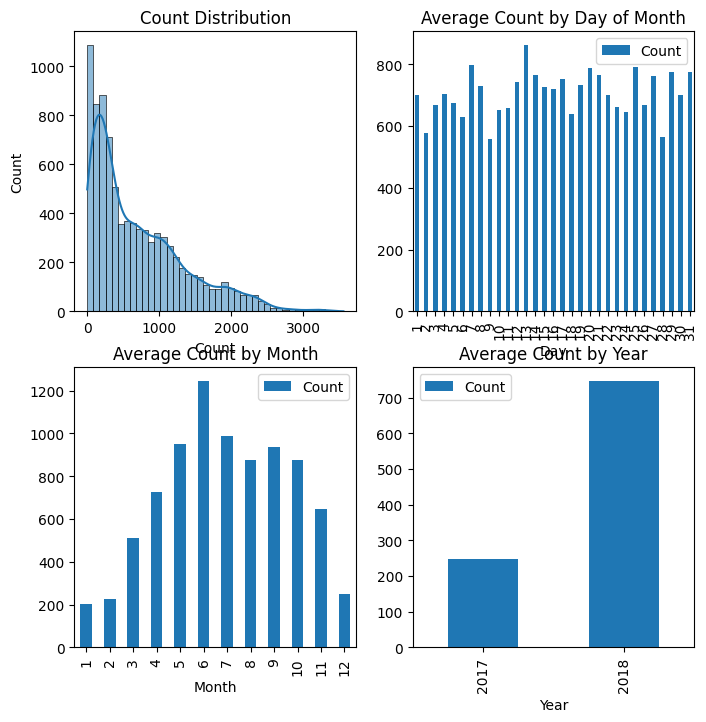

In [184]:


## plot average count over time to look for patterns that can be used to predict future demand
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(all_data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


## Set up representation

In [185]:
!pip install deap

In [186]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator
from IPython import display


In [187]:
## Prepare data for training
all_data['Windspeed'] = all_data['Wind speed']
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [188]:
all_data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [189]:
## Data standardisation
from sklearn import preprocessing

features = [
 'Weekend',
 'Month',
 'Hour',
 'Temp',
 'Windspeed',
 'Visibility']
# for feature in features:
scaler = preprocessing.StandardScaler()
# Fit the scaler to your data
scaler.fit(all_data[features])

# Transform the selected features
all_data[features] = scaler.transform(all_data[features])



In [190]:
features

['Weekend', 'Month', 'Hour', 'Temp', 'Windspeed', 'Visibility']

In [191]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput
        self.numHidden1 = numHidden1
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.b_i_h1 = [0] * numHidden1
        self.b_i_h2 = [0] * numHidden2
        self.b_i_output = [0] * numOutput

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feed_forward(self, inputs):

        h1 = np.dot(self.w_i_h1, inputs)             # feed input to hidden layer 1
        h1 = [h + b for h, b in zip(h1, self.b_i_h1)]

        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

        h2 = np.dot(self.w_h1_h2, h1)                # feed layer 1 to hidden layer 2
        h2 = [h + b for h, b in zip(h2, self.b_i_h2)]
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        output = [o + b for o, b in zip(output, self.b_i_output)]
        return output

    # Weights get set as:
    # Weights to layer h1, h2, o
    # Biases to layer h1, h2, o
    def set_weights_linear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        # Weights (multi-dimensional arrays)

        first_slice_end = numWeights_I_H1

        self.w_i_h1 = np.array(Wgenome[:first_slice_end])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

        second_slice_end = first_slice_end + numWeights_H1_H2

        self.w_h1_h2 = np.array(Wgenome[first_slice_end:second_slice_end])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        third_slice_end = second_slice_end + numWeights_H2_O

        self.w_h2_o = np.array(Wgenome[second_slice_end:third_slice_end])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

        # Biases (flat arrays for each layer)

        fourth_slice_end = third_slice_end + self.numHidden1

        self.b_i_h1 = np.array(Wgenome[third_slice_end:fourth_slice_end])

        fith_slice_end = fourth_slice_end + self.numHidden2

        self.b_i_h2 = np.array(Wgenome[fourth_slice_end:fith_slice_end])

        self.b_i_output = np.array(Wgenome[fith_slice_end:])

    def get_weights(self):
        return np.concatenate((self.w_i_h1.flatten(), self.w_h1_h2.flatten(), self.w_h2_o.flatten(), self.b_i_h1, self.b_i_h2, self.b_i_output))

In [192]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [193]:
import numpy
# randomise data
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = all_data.sample(frac=0.2)
train_data = all_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(test_data.size)

print(train_data.size)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


35040
140160


In [194]:

## Mean absolute error: On some regression problems, the distribution of the target variable may be mostly Gaussian, but may have outliers, e.g. large or small values far from the mean value.

def eval(individual, myNet, evdata):
  myNet.set_weights_linear(individual)
  fitness = 0
  preds = []
  for i in range(len(evdata)):
    input = [evdata['PublicHoliday'][i], evdata['Weekend'][i], evdata['Month'][i], evdata['Hour'][i], evdata['Temp'][i], evdata['Windspeed'][i], evdata['Visibility'][i], evdata["HireAvailable"][i]]
    output = myNet.feed_forward(input)
    preds.append(output)
    fitness += (evdata['Count'][i] - output[0])**2

  return fitness/len(evdata),





In [195]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.4)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)


myNet = MLP(num_input_nodes, num_hidden_nodes_1, num_hidden_nodes_2, num_output_nodes)

baseline = toolbox.evaluate(myNet.get_weights(), myNet, train_data)
print(baseline)

(932237.0941109314,)


In [196]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [197]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
print(ind.fitness.values)
print(len(ind.fitness.weights))
print(len(toolbox.evaluate(ind, myNet, train_data)))
print(ind.fitness.weights)
ind.fitness.values = toolbox.evaluate(ind, myNet, train_data)

print(ind.fitness.valid)
# print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet, train_data))

[-0.10189797303297254, -0.4307179830037391, 0.341136764012663, -0.6462057959893399, 0.7991209171176097, 0.26522516352499537, -0.8181089031371951, 0.4806755215985572, -0.12109025408831675, -0.5157539330467693, -0.9509830787436726, 0.9852330161408818, 0.9544048607033639, 0.9458813861772568, -0.2524395969189943, -0.9158121124555896, 0.5147032945812478, 0.8225149477730986, -0.26682501281617044, 0.48296833880070267, -0.6537995311605307, 0.0025346147801872387, 0.9373775983777488, -0.03551937624773749, -0.39934759784159324, -0.6601106112370168, 0.39804278285577865, 0.4215704395830746, -0.14591455805774123, -0.7399680441591876, 0.4012553840556268, -0.6915344648659691, 0.5958675834822524, -0.8564375673788927, -0.16407719809694554, 0.9785861807029519, -0.7342534461972792, -0.9408633103670074, 0.870503521387535, 0.16754069151542383, 0.6176303737638811, -0.23874740476591083, 0.8386711374687075, -0.4832263808254109, 0.18534213357868934, -0.2015961067211116, -0.7246521853989762, 0.9596347025449472, 

In [198]:
logbook = tools.Logbook()
hof = tools.HallOfFame(1)
pop = toolbox.population(n=50)

In [199]:
fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [200]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

    gen = [g] * 100
    hof.update(pop)
    if g%5==0:
      print(record)



-- Generation 0 --
{'avg': 912184.9847028774, 'std': 5903.925446724906, 'min': 896002.4192845316, 'max': 922153.7734705945}
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
{'avg': 853319.334544997, 'std': 17945.00773084655, 'min': 813931.9936626514, 'max': 892047.4651235621}
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
{'avg': 712775.4464788012, 'std': 40918.670530224364, 'min': 592313.1534209609, 'max': 794159.9066545778}
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
{'avg': 503413.59673134075, 'std': 47443.27257613755, 'min': 416276.36112658307, 'max': 589797.558198658}
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
{'avg': 310058.08813109854, 'std': 33904.320030536124, 'min': 244461.4615050688, 'max': 380642.13491498627}
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-

KeyboardInterrupt: 

In [201]:
print(logbook)
print([i[:1] for i in hof.items[:10]])



avg   	gen	max   	min   	std    
912185	0  	922154	896002	5903.93
906058	1  	921775	873590	9794.81
897181	2  	918215	869081	11207.9
884785	3  	906304	856647	11404.8
872940	4  	899937	841545	15229.9
853319	5  	892047	813932	17945  
831734	6  	879230	797804	17581.6
815552	7  	882251	722931	25363.5
788012	8  	843484	679299	32537.1
750706	9  	817895	626128	42198.7
712775	10 	794160	592313	40918.7
676951	11 	756933	532882	45400.7
623761	12 	742527	444397	51724.3
579546	13 	715938	409708	51596.4
538937	14 	624661	430700	44006.3
503414	15 	589798	416276	47443.3
467126	16 	557732	378224	43443.2
426813	17 	525825	320168	42476.7
390772	18 	480164	269725	49802.6
344918	19 	435504	248122	47119.7
310058	20 	380642	244461	33904.3
280812	21 	353214	239101	21525.7
271302	22 	313929	246446	13755.3
269289	23 	317039	238234	15734.2
263739	24 	304596	235047	16473.4
258144	25 	309176	232601	15880.7
252434	26 	289042	231852	13117.1
251714	27 	281176	230175	12174.4
248122	28 	326596	228529	16828.8
244230	29 

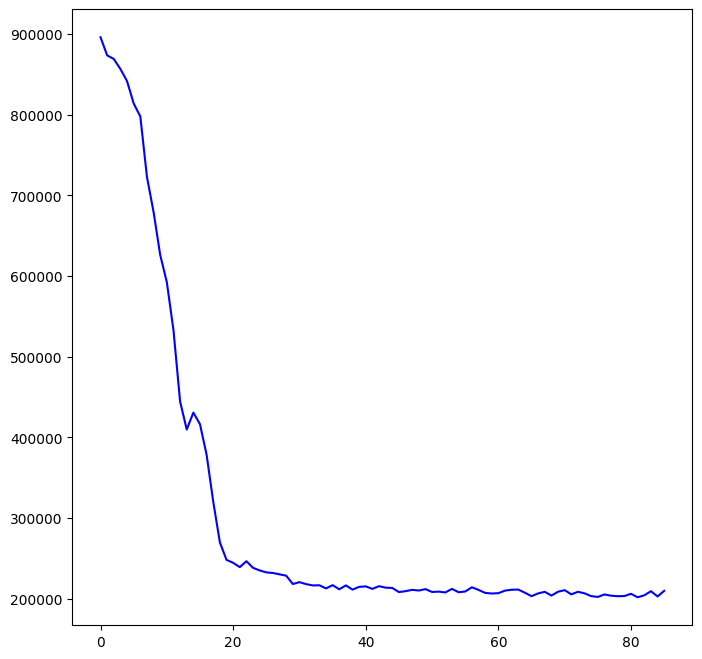

In [202]:
## graph of the min fitness value over generations
gen = logbook.select("gen")
fit_mins = logbook.select("min")
fit_maxs = logbook.select("max")
fit_avgs = logbook.select("avg")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(gen, fit_mins, "b", label="Minimum")


[-4.555369739124669, -3.0154828140803995, 5.199148649273113, -1.0730413823530365, 4.391527320941595, 3.414417918684059, -4.167104401779071, 2.4826128232018188, 2.4221306428334004, 1.5561331764929198, 1.9922426620953355, 2.177237543881507, -0.5297509567895669, 2.152792155448887, -3.118353663903821, -3.6048038528320214, -4.005877820682929, -0.030913377877143267, -3.536973945845391, 2.521493066783207, 3.1470716498655795, -2.199347524983987, -2.531324937348748, 0.9026957667344392, 3.9180753005131796, 4.2692871193480535, 4.3403723210742315, 1.3857723366711452, 2.301242693337179, 1.1255503727092315, 0.4276111959259558, 3.524541350952265, -3.9628627696102816, -3.0664248299566266, -0.2903966238342337, 0.5033915512872172, 2.4258676031048534, -0.3576057251938739, 0.42431997343948485, 0.9710733843816552, -2.6094486345212498, -0.7258448781724398, 3.1751095657550223, 5.564445303754293, -0.09817441004118205, -1.760566960598028, -0.922673534337779, 3.1369143870930856, 1.5908386299439208, 5.9968104034

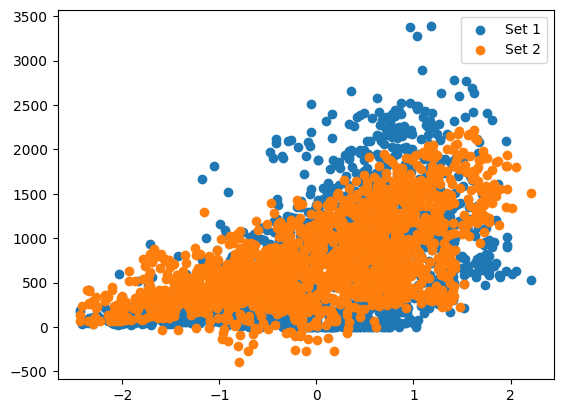

In [203]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
myNet.set_weights_linear(best_ind)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i], test_data["HireAvailable"][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

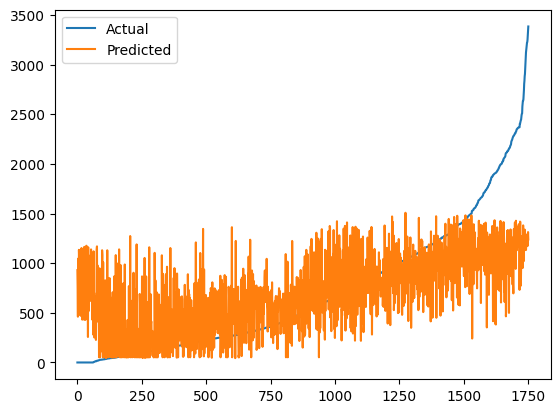

In [ ]:
best_ind = hof.items[0]

test_data.sort_values(by=['Count'], inplace=True)
test_data = test_data.reset_index(drop=True)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i], test_data["HireAvailable"][i]] for i in range(len(test_data))]
x = [i for i in range(len(test_data))]
y_values1 = test_data['Count'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs]
plt.plot(x, y_values1, label='Actual')
plt.plot(x, y_values2, label='Predicted')
plt.legend()
plt.show()

[-1.8064883428754341, -3.9265798333225437, -1.8823799855649215, -5.324537465785179, -1.7201359509124856, 7.302084807465165, -3.7230534349906415, -3.5801173308020102, 4.870073932241842, -0.9516875147305217, 1.9816617807720671, 1.66203930660329, -0.3301188786043178, -0.14642904860904965, 1.0708451022939893, 0.3452874274444697, 1.999845506056788, 3.2124533287167134, 4.648747305907465, 2.116093918405072, -3.0411621134126587, 4.073316475697847, -1.9619744061329927, 1.847721806449336, -2.877293460492272, -4.351436772850911, -9.03998903745597, -2.1333004049034234, 1.6153046017529942, -0.3767565897899512, 1.2470743576161512, 2.194376134140887, -2.0296145962891563, -0.638981923238878, -5.0597924379889765, -3.970530391424252, -2.5255392995668613, 0.8789734190290797, -6.667058306748179, -3.710666325981543, 5.295944346218073, -5.154294252915754, -7.869326282908662, -1.4373101345675157, 3.9379895476099263, -7.444415933524057, -2.9449516469022115, -11.736318463828713, -2.7259009383993824, 4.22675298

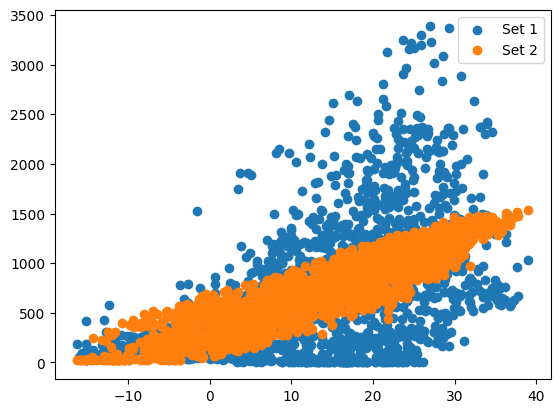

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof.items[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.set_weights_linear(best_ind)
inputs = [[test_data['Season'][i], test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i], test_data["HireAvailable"][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[[708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337

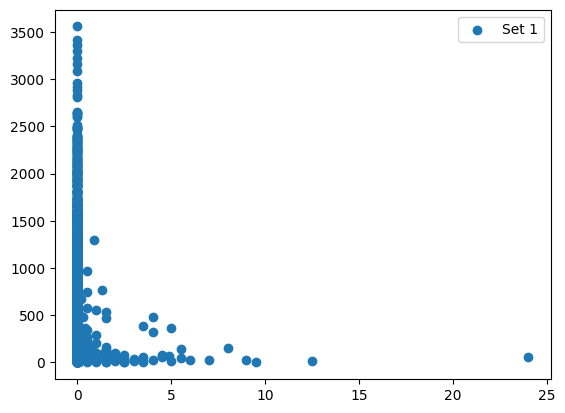

[29.096660147330937, 12.581272755715162, -0.38149388340117474, 4.957464629270712, 17.309974820025115, 11.415954409279552, -11.676366097190355, 0.046927422359391735, 9.779333286707804, 29.47839321443361, -5.395387520191839, 9.337687348597694, 14.92676670717382, -11.369634820100051, 26.64884397584116, 5.903664444034511, 15.717840450901218, 5.509973022960861, -24.074342490914763, 12.147669431831458, -5.429587036006186, 10.482114204623247, -11.919175301840948, 10.506377839387271, 1.6407556159264127, -11.942255391677476, 2.046754985028316, -4.5900594614014665, 17.106176546169976, -14.542911608606264, 4.4709820457791505, 1.5143974938124862, 12.675046211125776, 14.02482130623536, -8.205001241605178, 10.284344532687994, 9.542702385525882, 27.737329178993306, -7.330473267391048, 0.032744458846772684, -18.402472558215923, -7.099667658461653, 17.608404934296434, -4.666802491783139, -10.08339554606045, 7.750222360437842, 3.19722542153973, -5.676025704269632, -6.013707791185976, 10.8650930785805, -

In [ ]:
# Assuming you have two sets of data:
x_values1 = test_data['Rain'].to_list()
y_values1 = test_data['Count'].to_list()

# x_values2 = test_data['Rain'].to_list()
# y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
# plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()
print(best_ind)

In [ ]:
# Assuming you have two sets of data:
x_values1 = evdata['Month'].to_list()
y_values1 = evdata['Count'].to_list()

x_values2 = evdata['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

NameError: name 'evdata' is not defined

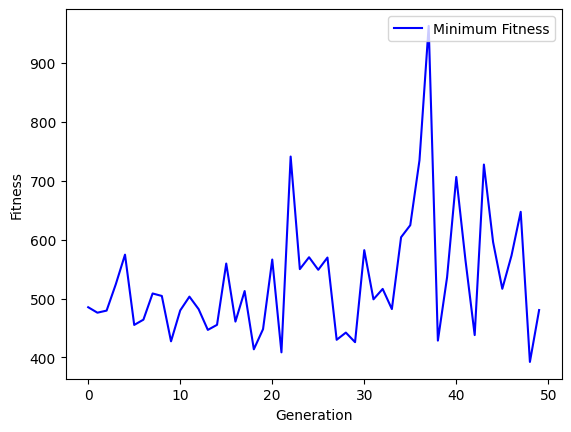

In [ ]:
## Graph fitness over generations

gen = logbook.select("gen")
fit_mins = logbook.select("min")


plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")

plt.show()